In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [ ]:
# 데이터셋 로드. as_supervised=True는 (이미지, 라벨) 튜플 형태로 데이터를 반환합니다.
(train_ds, validation_ds, test_ds), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

# 라벨 정보 확인 (고양이: 0, 개: 1)
class_names = metadata.features['label'].names
print("클래스 이름:", class_names)

# 데이터 개수 확인
num_train_examples = metadata.splits['train[:80%]'].num_examples
num_validation_examples = metadata.splits['train[80%:90%]'].num_examples
num_test_examples = metadata.splits['train[90%:]'].num_examples

print(f"훈련 데이터 개수: {num_train_examples}")
print(f"검증 데이터 개수: {num_validation_examples}")
print(f"테스트 데이터 개수: {num_test_examples}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.QGGHNL_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
클래스 이름: ['cat', 'dog']
훈련 데이터 개수: 18610
검증 데이터 개수: 2326
테스트 데이터 개수: 2326


In [ ]:
IMG_SIZE = 150
BATCH_SIZE = 64

# 이미지 크기 조절 및 정규화 함수
def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

# 데이터 파이프라인 생성
# .map() : 모든 데이터에 함수를 적용
# .cache() : 데이터를 메모리에 캐시하여 다음 에포크부터 속도 향상
# .shuffle() : 데이터를 섞어서 과적합 방지
# .batch() : 데이터를 배치 크기만큼 묶음
# .prefetch() : 훈련 중인 데이터 외에 다음 데이터를 미리 준비하여 성능 향상
train_batches = train_ds.map(format_image).cache().shuffle(num_train_examples).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_batches = validation_ds.map(format_image).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batches = test_ds.map(format_image).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2

# 1. 데이터 증강 레이어 생성
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
])

# 2. 사전 학습된 MobileNetV2 모델 불러오기 (분류기는 제외)
conv_base = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                        include_top=False,
                        weights='imagenet')

# 3. 사전 학습된 모델의 가중치 동결
conv_base.trainable = False

# 4. 전체 모델 조립
model = Sequential([
    # 입력 이미지를 먼저 증강 레이어에 통과시킴
    data_augmentation,
    # 그 다음 사전 학습 모델에 통과시킴
    conv_base,
    # Flatten 대신 GlobalAveragePooling2D 사용 (과적합 방지에 더 효과적)
    layers.GlobalAveragePooling2D(),
    # 드롭아웃 레이어
    layers.Dropout(0.5),
    # 최종 분류기
    layers.Dense(1, activation='sigmoid')
])

model.summary()

/tmp/ipython-input-1180960328.py:12: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  conv_base = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping

# val_loss를 지켜보다가 3번 연속으로 성능 향상이 없으면 학습을 중단
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

EPOCHS = 20

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=validation_batches,
    callbacks=[early_stopping]
)

Epoch 1/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 51s 73ms/step - accuracy: 0.6440 - loss: 0.7807 - val_accuracy: 0.9205 - val_loss: 0.2103
Epoch 2/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 54s 62ms/step - accuracy: 0.8164 - loss: 0.4096 - val_accuracy: 0.9411 - val_loss: 0.1534
Epoch 3/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.8530 - loss: 0.3405 - val_accuracy: 0.9488 - val_loss: 0.1336
Epoch 4/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.8689 - loss: 0.3033 - val_accuracy: 0.9518 - val_loss: 0.1263
Epoch 5/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.8721 - loss: 0.2882 - val_accuracy: 0.9527 - val_loss: 0.1226
Epoch 6/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 18s 62ms/step - accuracy: 0.8789 - loss: 0.2802 - val_accuracy: 0.9579 - val_loss: 0.1155
Epoch 7/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - accuracy: 0.8799 - loss: 0.2765 - val_accuracy: 0.9544 - val_loss: 0.1163
Epoch 8/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.8953 - loss: 0.2486 - 

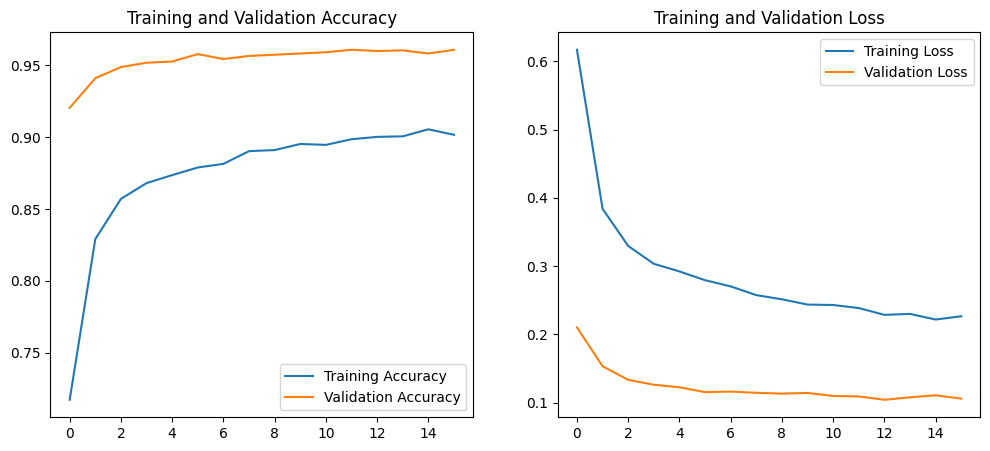


[최종 테스트 평가]
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.9700 - loss: 0.0881
테스트 손실 (Loss): 0.0862329825758934
테스트 정확도 (Accuracy): 0.969475507736206


In [ ]:
# 1. 학습 과정 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 2. 최종 성능 평가 (한 번도 본 적 없는 테스트 데이터 사용)
print("\n[최종 테스트 평가]")
test_loss, test_accuracy = model.evaluate(test_batches)
print(f"테스트 손실 (Loss): {test_loss}")
print(f"테스트 정확도 (Accuracy): {test_accuracy}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
모델의 예측 값 (0에 가까우면 고양이, 1에 가까우면 개): 0.9987272620201111
이 이미지는 강아지입니다..


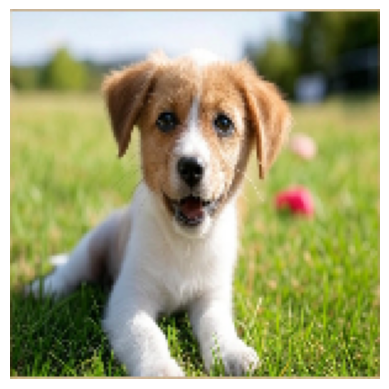

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# 1. Colab에 직접 업로드한 이미지 파일 경로를 지정하세요.
image_path = '/content/Test_dog.jpg'

try:
    # 2. 이미지 불러오기 및 전처리
    img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # 3. 모델로 예측 수행
    prediction = model.predict(img_array)
    print(f"모델의 예측 값 (0에 가까우면 고양이, 1에 가까우면 개): {prediction[0][0]}")

    # 4. 결과 해석
    if prediction[0][0] > 0.5:
      print("이 이미지는 강아지입니다..")
    else:
      print("이 이미지는 고양이입니다")

    # 5. 이미지 확인
    plt.imshow(img)
    plt.axis('off')
    plt.show()

except FileNotFoundError:
    print(f"오류: '{image_path}' 파일을 찾을 수 없습니다. Colab에 파일이 정확히 업로드되었는지, 파일 이름이 올바른지 확인해주세요.")
except Exception as e:
    print(f"오류 발생: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
모델의 예측 값 (0에 가까우면 고양이, 1에 가까우면 개): 0.0011947732418775558
이 이미지는 고양이입니다.


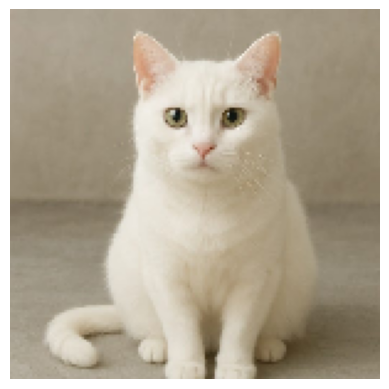

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# 1. Colab에 직접 업로드한 이미지 파일 경로를 지정하세요.
image_path = '/content/Test_cat.jpg' # <-- 이 부분을 업로드한 파일 이름에 맞게 수정!

try:
    # 2. 이미지 불러오기 및 전처리
    img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # 3. 모델로 예측 수행
    prediction = model.predict(img_array)
    print(f"모델의 예측 값 (0에 가까우면 고양이, 1에 가까우면 개): {prediction[0][0]}")

    # 4. 결과 해석
    if prediction[0][0] > 0.5:
      print("이 이미지는 강아지입니다.")
    else:
      print("이 이미지는 고양이입니다.")

    # 5. 이미지 확인
    plt.imshow(img)
    plt.axis('off')
    plt.show()

except FileNotFoundError:
    print(f"오류: '{image_path}' 파일을 찾을 수 없습니다. Colab에 파일이 정확히 업로드되었는지, 파일 이름이 올바른지 확인해주세요.")
except Exception as e:
    print(f"오류 발생: {e}")

In [ ]:
!pip install git+https://github.com/solapi/solapi-python.git

  Cloning https://github.com/solapi/solapi-python.git to /tmp/pip-req-build-eqs212vd
  Running command git clone --filter=blob:none --quiet https://github.com/solapi/solapi-python.git /tmp/pip-req-build-eqs212vd
  Resolved https://github.com/solapi/solapi-python.git to commit b77fdd9e29e27a1eec61b364a2bfa919b20afd45
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for solapi: filename=solapi-5.0.2-py3-none-any.whl size=25562 sha256=df1c3e039ea1306c7fa6c12e39fb40206e03af92000ae1491707d34e9d8aeba8
  Stored in directory: /tmp/pip-ephem-wheel-cache-gr4s7jzf/wheels/73/a8/3b/60c98afce6fb1408e9a94f4894dfa1a7c7a7f06f7f66df5b27
Successfully built solapi


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
모델 예측 값: 0.0010262374999001622
✅ 모델 판단: '고양이'입니다. Solapi로 문자 메시지를 보냅니다!.
문자 메시지 요청 성공: {'groupId': 'G4V20251029153313JBPQ9ZO87JG10B6', 'to': '01072109735', 'from': '01072109735', 'type': 'SMS', 'statusMessage': '정상 접수(이통사로 접수 예정) ', 'country': '82', 'messageId': 'M4V20251029153313ON2I6JHQGKK6Z1L', 'statusCode': '2000', 'accountId': '25100203337353'}


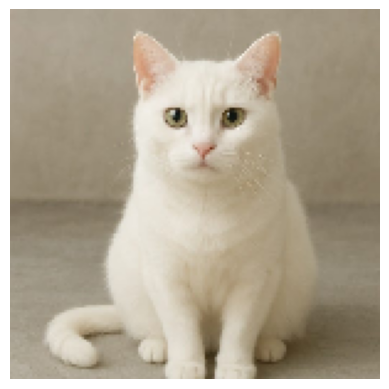

In [ ]:
import requests
import json
import uuid
import time
import hmac
import hashlib

SOLAPI_API_KEY = 'API_KEY'           # 본인의 API Key
SOLAPI_API_SECRET = 'API_SECRET_KEY'     # 본인의 API Secret
SOLAPI_SENDER_NUMBER = 'SEND_PHONE_NUMBER'             # 인증받은 내 발신번호 ('-' 없이)
MY_PHONE_NUMBER = 'MY_PHONE_NUMBER'                  # 문자를 받을 내 실제 전화번호 ('-' 없이)


def get_iso_datetime():
    """ISO 8601 형식의 현재 시간 반환"""
    return time.strftime('%Y-%m-%dT%H:%M:%S.000Z', time.gmtime())

def get_signature(api_secret, salt, date):
    """HMAC-SHA256 시그니처 생성"""
    uri = "/messages/v4/send"  # 반드시 전송 요청 uri를 입력해야 합니다
    message = date + salt + uri
    return hmac.new(api_secret.encode(), message.encode(), hashlib.sha256).hexdigest()

def get_signature(api_secret, salt, date):
    """(수정) HMAC-SHA256 시그니처 생성"""
    key = api_secret.encode()
    # Solapi v4 API의 규칙은 date와 salt만으로 메시지를 구성합니다.
    msg = (date + salt).encode()
    return hmac.new(key, msg, hashlib.sha256).hexdigest()

def send_solapi_message_raw(message_text):
    """(수정) 라이브러리 없이 지정된 내용으로 문자 메시지를 보내는 함수"""
    try:
        # --- Solapi API의 공식 인증 규칙 ---
        salt = str(uuid.uuid4())
        date = get_iso_datetime()
        # 수정된 함수를 호출합니다.
        signature = get_signature(SOLAPI_API_SECRET, salt, date)

        # --- 요청 헤더 구성 ---
        headers = {
            'Authorization': f'HMAC-SHA256 ApiKey={SOLAPI_API_KEY},Date={date},salt={salt},signature={signature}',
            'Content-Type': 'application/json; charset=utf-8'
        }

        # --- 요청 본문(Body) 구성 ---
        data = {
            "message": {
                "to": MY_PHONE_NUMBER,
                "from": SOLAPI_SENDER_NUMBER,
                "text": message_text
            }
        }

        # --- API 요청 보내기 ---
        url = "https://api.solapi.com/messages/v4/send"
        response = requests.post(url, headers=headers, json=data)
        response.raise_for_status()

        print("문자 메시지 요청 성공:", response.json())

    except requests.exceptions.HTTPError as e:
        # 오류 발생 시 더 자세한 내용을 출력하도록 수정
        print(f"문자 메시지 요청 실패 (HTTP 오류): {e.response.status_code}")
        print(f"오류 내용: {e.response.json()}")
    except Exception as e:
        print(f"문자 메시지 요청 실패 (기타 오류): {e}")


# --- 이미지 예측 코드는 이전과 동일합니다 ---

# 1. 이미지 파일 경로 지정
image_path = '/content/Test_cat.jpg'

try:
    # 2. 이미지 불러오기 및 전처리
    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # 3. 모델로 예측 수행 (model 변수가 정의되어 있어야 함)
    prediction = model.predict(img_array)
    prediction_value = prediction[0][0]
    print(f"모델 예측 값: {prediction_value}")

    # 4. 결과 해석 및 Solapi 문자 발송
    if prediction_value > 0.5:
        print("✅ 모델 판단: '개'입니다. Solapi로 문자 메시지를 보냅니다!")
        sms_body = "시스템에서 강아지가 감지되었습니다."
        send_solapi_message_raw(sms_body) # <-- 라이브러리 없는 함수 호출
    else:
        print("✅ 모델 판단: '고양이'입니다. Solapi로 문자 메시지를 보냅니다!.")
        sms_body = "시스템에서 고양이가 감지되었습니다."
        send_solapi_message_raw(sms_body) # <-- 라이브러리 없는 함수 호출

    # 5. 이미지 확인
    plt.imshow(img)
    plt.axis('off')
    plt.show()

except NameError as e:
    print(f"오류: '{e.name}' 변수가 정의되지 않았습니다. 모델('model')이나 이미지 크기 변수가 있는지 확인해주세요.")
except FileNotFoundError:
    print(f"오류: '{image_path}' 파일을 찾을 수 없습니다.")
except Exception as e:
    print(f"오류 발생: {e}")